# deeps

_Attempt at for solving Comma.ai's speed challenge_

This approach uses optical flow analysis and Convolutional neural networks to estimate the speed of a car using a dashcam footage of the car. We are provided with a training video (train.mp4) and the speed data at each frame  (train.txt).

- **train.mp4:** 20 fps video with 20400 frames, each frame is 640(w) x 840(h) x 3 (RGB)
- **train.txt:** Text file with speed data at each frame
- **test.mp4:** 20 fps video with 20400 frames, each frame is 640(w) x 840(h) x 3 (RGB)

## Dependencies

- **os:** For manupulating local file system
- **cv2:** For image processing and optical flow
- **numpy:** For vector calculations
- **pandas:** For accessing dataset
- **matplotlib:** For plotting data and displaying images
- **tensorflow:** For training neural networks
- **keras:** For creating neural network architecture

In [1]:
import csv

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
%matplotlib inline

## Video to Images

To make my life easy, I decided to capture the video frames and save them to `.jpg` files under `data/training_frames` instead of directly processing the video. This is computationally less efficient but it makes the processing pipeline much easier. Besides generating images, I also generated a `.csv` file to corelate the frames with speed data.

I used [openCV’s VideoCapture](http://docs.opencv.org/3.1.0/d8/dfe/classcv_1_1VideoCapture.html) to capture and save the images. These frames could have been cached and processed straight from the video.

In [3]:
def capture_frames(video_source, speed_data):
    
    '''
    Captures .mp4 video frames to .jpg images and creates a .csv to store the capture information
    '''
    
    num_frames = speed_data.shape[0]
    
    # create VideoCapture instance
    cap = cv2.VideoCapture(video_source)
    # set frame count
    cap.set(cv2.CAP_PROP_FRAME_COUNT, num_frames)
    
    with open('./data/driving.csv', 'w') as csvfile:
        fieldnames = ['image_path', 'frame', 'speed']
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()

        for idx in xrange(num_frames):
            # set frame index
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            # read the frame
            success, image = cap.read()

            if success:
                image_path = os.path.join('./data/training_frames/', str(idx) + '.jpg')

                # save image to IMG folder
                cv2.imwrite(image_path, image)

                # write row to driving.csv
                writer.writerow({'image_path': image_path,
                         'frame': idx,
                         'speed': speed_data[idx],
                        })
            else:
                print 'Failed to read frame ', idx
        
        print 'Done!'

This function was only called once to save the images. Now that we have our images, we can disregard this function and the video, and just work with image data.

In [4]:
#capture_frames('data/train.mp4',np.loadtxt('data/train.txt'))

In [5]:
ls data

driving.csv      test_frames/     train.txt
test.mp4         train.mp4        training_frames/


## Making sense of the data

We have the images and its corresponding speed data, but just training a model with a raw RGB image input and speed value output isn't going to yield the results we are looking for. 

### Position, Velocity, Acceleration: 
**Here's why:** Having a single image frame alone doesn’t tell us much about the speed. If we think in terms of classical mechanics, you can estimate the position of an object based on a single frame, but to estimate the velocity you need at least two frames because you need a time reference. Velocity is in units: (distance / time). In our case our distance is measured in meters, and our time is measured in seconds. To calculate velocity we need at least two successive frames. To calculate acceleration, which is the change in velocity, we will need ~3 frames, because we will need to calculate how the velocity (2 frames) changes over time (3rd frame). Acceleration is in units (meters / second²).

So knowing that we need at least two frames, it is important to be able to grab pairs of images. Let’s call the current image `image_current` and the next image `image_next` for the time being. When we train our network we want to pass in shuffled data, because we don’t want it to learn the video sequence as is, we want it to be able to generalize to any video, and any given sub-sequence.

**Double and shuffle:** I doubled the dataset, and shuffled by pairs. I need to keep frames together in pairs because that is how I will ultimately determine speed.

In [2]:
df = pd.read_csv('/srv/beegfs02/scratch/aegis_guardian/data/speed_prediction/train_processed.csv')
# df = df.iloc[:5000]
df.columns = ['image_path', 'time', 'speed']
print("Data Loaded Successfully...")
print(f"Dataset Size: {len(df)}")
print(df.head())

Data Loaded Successfully...
Dataset Size: 99999
                                          image_path      time     speed
0  /srv/beegfs02/scratch/aegis_guardian/data/spee...  0.166667  0.500541
1  /srv/beegfs02/scratch/aegis_guardian/data/spee...  0.250000  0.501369
2  /srv/beegfs02/scratch/aegis_guardian/data/spee...  0.333333  0.502367
3  /srv/beegfs02/scratch/aegis_guardian/data/spee...  0.416667  0.503638
4  /srv/beegfs02/scratch/aegis_guardian/data/spee...  0.500000  0.504758


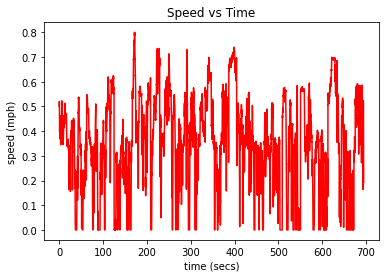

In [3]:
video_fps = 12
times = np.asarray(df['time'], dtype = np.float32) / video_fps
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.xlabel('time (secs)')
plt.ylabel('speed (mph)')
plt.show()

In [8]:
df.tail(5)

,image_path,frame,speed
20395,./data/training_frames/20395.jpg,20395,2.329180
20396,./data/training_frames/20396.jpg,20396,2.289795
20397,./data/training_frames/20397.jpg,20397,2.292917
20398,./data/training_frames/20398.jpg,20398,2.260600
20399,./data/training_frames/20399.jpg,20399,2.206759


In [4]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    randomized_list = np.arange(len(dframe)-1)
    np.random.shuffle(randomized_list)
    
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for i in randomized_list:
        idx1 = i
        idx2 = i + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(10)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt == 2:
            test_frames = [test_data, row1, row2]
            test_data = pd.concat(test_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt > 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data, test_data

In [5]:
# create training and validation set
train_data, valid_data, test_data = batch_shuffle(df)

# verify data size
print ('Training data size =', train_data.shape)
print ('Validation data size =', valid_data.shape)
print ('Test data size =', test_data.shape)

Training data size = (140088, 4)
Validation data size = (40096, 4)
Test data size = (19812, 4)


## Preprocessing

### Raw Images

Let's take a look at the raw image data

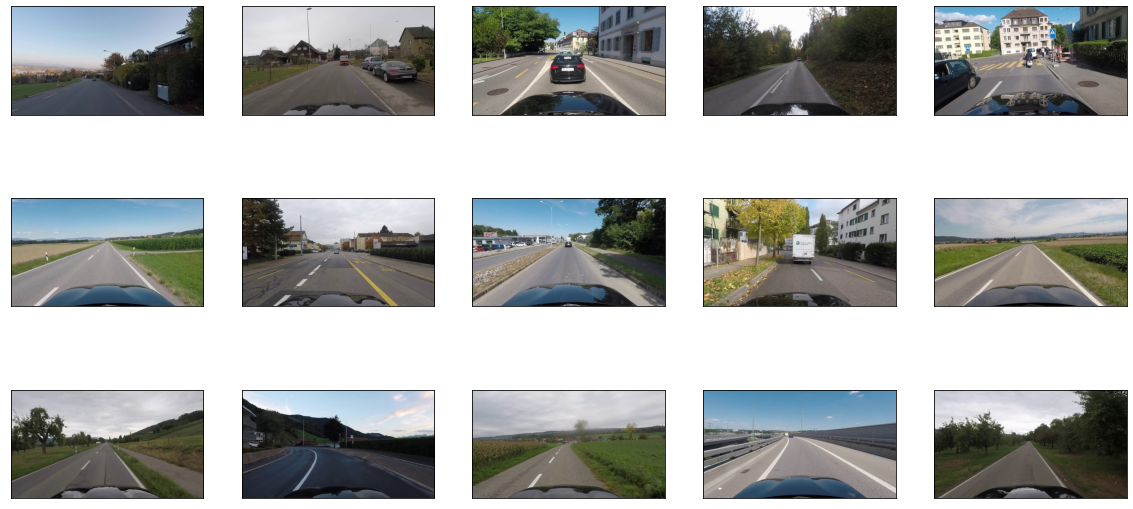

In [6]:
x = random.sample(range(1,len(train_data)), 15)

plt.figure(1, figsize=(20,10))
for i,value in enumerate(x):
    img = mpimg.imread(train_data.iloc[value]['image_path'])
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

### Brightness Augmentation

The video has a mixture of light and dark scenarios. Sometimes roads can have shadows on them while sometimes they are well lit. To make the model more robust, I added brightness augmentation in my pre-processing pipeline. This will randomly change the brightness of the images during training. 

In [7]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

### Choosing a metric

We want a metric that captures the information between two successive image frame such that it strongly coorelates with the speed data. There are many different ways to define this metric. I started experimenting with the data to find something distinguishable.

These are all the metrics that weren't successful. [Mean Square Error(MSE)](https://www.google.ca/search?q=mean+square+error&oq=mean+square+&aqs=chrome.0.0j69i57j0l4.2343j0j7&sourceid=chrome&ie=UTF-8) was always over 15 with these methods.

_I converted them all to RGB before feeding them into the network._

- RGB Difference (image_current_RGB - image_next_RGB)
- HSV Difference (image_current_HSV - image_next_HSV)
- Saturation difference (image_current_sat — image_next_sat)
- Inverted Saturation difference (image_next_sat — image_current_sat)
- Hue difference (image_current_hue — image_next_hue)

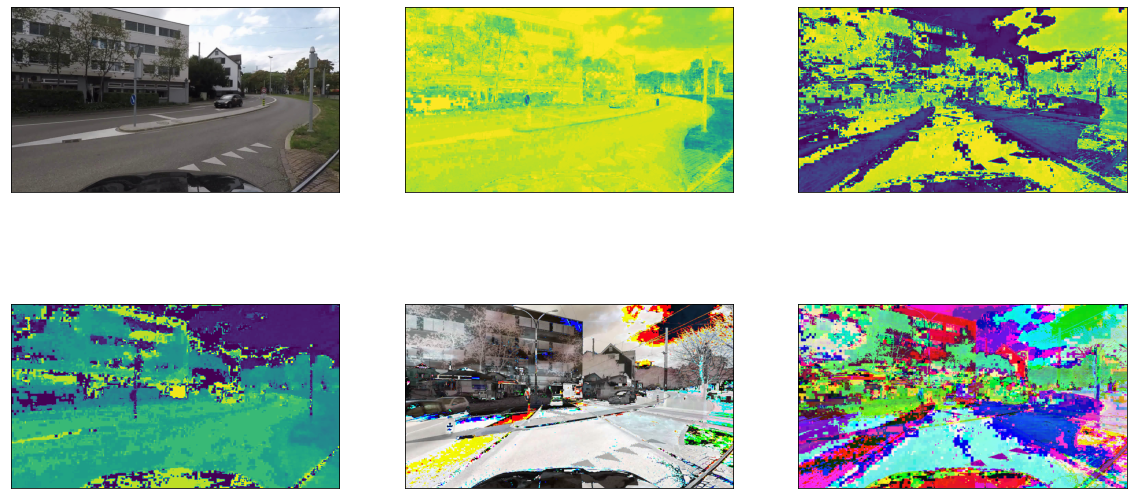

In [9]:
import cv2
img1 = mpimg.imread(train_data.iloc[34]['image_path'])
img2 = mpimg.imread(train_data.iloc[23]['image_path'])

rgb_diff = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) - cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
hsv_diff = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV) - cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
sat = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)[:,:,1] - cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,1]
inv_sat = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,1]*-1 
hue = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,0]

plt.figure(1, figsize=(20,10))

plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(img2)

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(inv_sat)

plt.subplot(2,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(sat)

plt.subplot(2,3,4)
plt.xticks([])
plt.yticks([])
plt.imshow(hue)

plt.subplot(2,3,5)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)

plt.subplot(2,3,6)
plt.xticks([])
plt.yticks([])
plt.imshow(hsv_diff)

### Optical Flow

I bumped across optical flow while researching and decided to give it a shot. This is Optical flow's definition from Wikipedia - "Optical flow or optic flow is the pattern of apparent motion of objects, surfaces, and edges in a visual scene caused by the relative motion between an observer and a scene." It is clear why this gave promising result. It measures motion of objects in a visual scene!

I used [The Farneback method](http://lmi.bwh.harvard.edu/papers/pdfs/gunnar/farnebackSCIA03.pdf) to calculate the dense optical flow. It means that it computes the optical flow from each pixel point in the current image to each pixel point in the next image.

I trained the model with a few different strategies and got the best result with the last one in the list
1. Get optical flow, then convert HSV to RGB
2. Get optical flow, convert HSV to RGB, then overlay it ontop of original image 
3. Get optical flow parameters (ang, magnitude) and expand dimensions of original image to H x W x R x G x B x Ang x Magnitude
4. Send in the flow differences as RGB (best result)

In [10]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

**Explanation:** I simply computed the optical flow and then grabbed the magnitudes and angles of the flow. I created a data object to store my results. data grabbed the grayscale version of image_next and set that to its saturation value. data then saved the angles to its hue value and the magnitude’s to its value value. HSV stands for hue, saturation, value. I then send rgb_flow into my network.

<img src="https://raw.githubusercontent.com/millingab/deeps/master/images/hsv.png" alt="HSV" style="width: 500px;"/>

_Notice how hue should go from 0-> 360 and magnitude from (0 -> 255)._



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


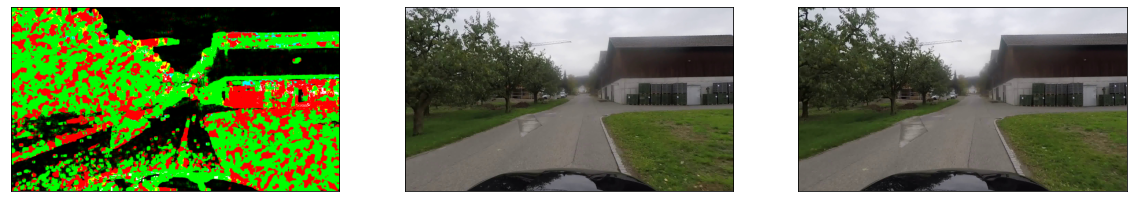

In [15]:
img1 = mpimg.imread(train_data.iloc[0]['image_path'])
img2 = mpimg.imread(train_data.iloc[1]['image_path'])

rgb_diff = opticalFlowDense(img1,img2)

plt.figure(1, figsize=(20,10))

plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)
plt.savefig('optflow.jpg')

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(img1)

plt.subplot(2,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(img2)

### Cropping
It’s a good idea to crop out unnecessary information from the image, stuff like the hood of the car and sky can go. I resized the image to (66, 220) for my network because that’s what my neural network architecture expects.

I also created a few nice functions to help me process each image, so I can work with the image paths directly from the generator.

In [20]:
def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[130:370,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

**For validation data:**

In [21]:
def preprocess_image_valid_from_path(image_path, scale_factor=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img, scale_factor)
    return img

**For training data:**

In [22]:
def preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)
    img = crop_image(img, scale_factor)
    return img

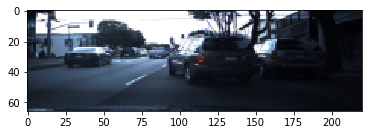

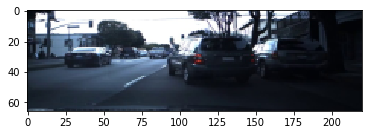

In [23]:
img = preprocess_image_from_path(train_data.iloc[404]['image_path'])
img_next = preprocess_image_from_path(train_data.iloc[405]['image_path'])

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img_next)

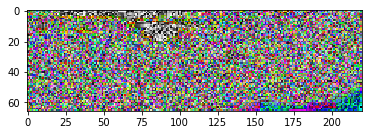

In [24]:
rgb_flow = opticalFlowDense(img,img_next)
plt.figure()
plt.imshow(rgb_flow)

### Generators

It is very efficient to use generators to actually process the images because most machines do not have enough memory to hold all the images when batching.

**Generators**

- This is used to yield train batches of rgb_flow and average speed.
- Since the data is already shuffled, we can segment the data as it is and yield
- Generators allow me to not clog my memory stack so I can perform these operations. 

In [25]:
def generate_training_data(data, batch_size = 16, scale_factor = 0.5):
    # sample an image from the data to compute image size
    img = preprocess_image_from_path(train_data.iloc[1]['image_path'],scale_factor)

    # create empty batches
    image_batch = np.zeros((batch_size, img.shape[0], img.shape[1], img.shape[2]))
    label_batch = np.zeros(batch_size)
    i=0
    
    while True:
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
        
        bright_factor = 0.2 + np.random.uniform()
        img1 = preprocess_image_from_path(data.iloc[i]['image_path'],scale_factor,bright_factor)
        img2 = preprocess_image_from_path(data.iloc[i+1]['image_path'],scale_factor,bright_factor)
        
        rgb_flow_diff = opticalFlowDense(img1, img2)
        avg_speed = np.mean([speed1,speed2])
        
        image_batch[(i/2)%batch_size] = rgb_flow_diff
        label_batch[(i/2)%batch_size] = avg_speed
        
        if not(((i/2)+1)%batch_size):
            yield image_batch, label_batch
        i+=2
        i=i%data.shape[0]

In [26]:
def generate_validation_data(data, batch_size = 16, scale_factor = 0.5):
    i=0
    while i < len(data):
        speed1 = data.iloc[i]['speed']
        speed2 = data.iloc[i+1]['speed']
    
        img1 = preprocess_image_from_path(data.iloc[i]['image_path'],scale_factor)
        img2 = preprocess_image_from_path(data.iloc[i+1]['image_path'],scale_factor)
        
        rgb_diff = opticalFlowDense(img1, img2)
        rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
        avg_speed = np.array([[np.mean([speed1,speed2])]])
        
        yield rgb_diff, avg_speed

## Network Architecture

I used an end to end learning architecture based on [Nvidia’s paper](https://arxiv.org/pdf/1604.07316v1.pdf). Let’s pretend the input was (480, 640, 3) for this case.

For classification we typically use a softmax at the end of our network so we can convert from scores to probabilities. For regression simply leave out the softmax and output the result of the last fully connected layer (perceptron).

<img src="https://raw.githubusercontent.com/millingab/deeps/master/images/nn_architecture.jpeg" alt="HSV" style="width: 500px;"/>

### Nvidia Model

I added extra filters to try to capture more data. Architecture changed as a result of added dimensions.

In [27]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


### Training parameters
**Optimizer:** Adam

**loss:** MSE

**epoch:** 25

**Samples per epoch:** 400

**Batches per sample** 32 images, 16 optical flow rgb_diffs

I trained the model several times, all with difference MSE values.
When I trained the model by passing in simple RGB image differences as my discernible metric I received rather poor results. My Mean Square Error was ~20. When I used dense optical flow as the discernible metric my loss looks like this:
On 25 epochs, the final MSE was 3.4.

Remember, after we train the model I want to use the weights to perform linear regression: where I will simply take my weight matrix and multiply it with the input to predict the speed. This is not a classification task.

**Define Training Parameters**

In [28]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16
print 'val_size: ', val_size

val_size:  8230


In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'model-weights-Vtest3.h5'
# earlyStopping = EarlyStopping(monitor='val_loss', 
#                               patience=1, 
#                               verbose=1, 
#                               min_delta = 0.23,
#                               mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint]

### Explanation of variables
**patience = 1:** Allow a 1 epoch tolerance where the validation loss may not decrease by min_delta.

**min_delta = 0.4:** Only re-save the weights with the next epoch values if the validation loss decreases by 0.4 or more.

**verbose = 1:** Print the output of the monitor for each epoch to the console.

## Train

In [30]:
model = nvidia_model()
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, BATCH)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 25,
    callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
400/400 [==============================] - 333s - loss: 61.9783 - val_loss: 83.2920
Epoch 2/25
400/400 [==============================] - 323s - loss: 28.2143 - val_loss: 78.1836
Epoch 3/25
400/400 [==============================] - 325s - loss: 21.3395 - val_loss: 42.5330
Epoch 4/25
400/400 [==============================] - 324s - loss: 17.1150 - val_loss: 28.9997
Epoch 5/25
400/400 [==============================] - 330s - loss: 15.0295 - val_loss: 30.2761
Epoch 6/25
400/400 [==============================] - 331s - loss: 13.5352 - val_loss: 25.7209
Epoch 7/25
400/400 [==============================] - 325s - loss: 11.9692 - val_loss: 9.3069
Epoch 8/25
400/400 [==============================] - 334s - loss: 10.8761 - val_loss: 1.4519
Epoch 9/25
400/400 [==============================] - 330s - loss: 10.2443 - val_loss: 9.6630
Epoch 10/25
400/400 [==============================] - 327s - loss: 9.3623 - val_loss: 5.8259
Epoch 11/25
400/400 [==============================] -

['loss', 'val_loss']


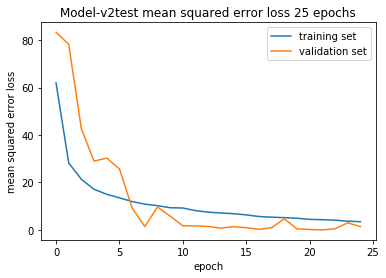

In [40]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model-v2test mean squared error loss 25 epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
# plt.show()
plt.savefig('loss_over_training.png')

## Results

I got a MSE of 3.48 on training data and a MSE of 1.4 on validation data. Even though the validation curve has some noise, the overall trend suggests that we are not overfitting the training set. 

This was a iterative process like all Deep Learning projects are. This is a list of things I tuned / experimented with:
- **Inputs:** _check preprocessing section of this notebook to see the different inputs I used_
- **Hyperparameters:** epoch, batch_size, steps_per_epoch
- **Optimizers:** Batch Gradient Descent, RMS Prop, Momentum, Adam Optimizer

## What I learned from this project

1. Optical flow is a powerful tool to measure motion of objects in images.
2. Adam Optimizer converges faster because it uses momentum and RMS prop to modify the gradient during descent
3. Python generators can be used to yield batches of data. They are very efficient for image processing because most machines do not have enough memory to hold all the images when batching.
4. Video and image processing using OpenCV
5. Training on local machine is horrible for training algorithms. Always use cloud services. This also helps you train multiple models in parallel. (Mo money you spend, mo problems you solve)